In [1]:
import json
import geojson
from data_fusion import DataFusion
import pandas as pd
from IPython.display import IFrame, Image
import folium

# Data Fusion Pipeline

The following example illustrates the data fusion process to explore the relationship between aerial ir defect analysis and photovoltaic short-term performance in PV systems. First, we read in the defect mapping that maps the defect id to the defect name and make it into a dictionary to declare the master data fusion class.

In [2]:
# Read in defect mapping to map defect id to defect name
with open("zeitvew_defect_mapping.json") as json_file:
    defect_mapping = json.load(json_file)
# Manipulate defect mapping to have "defect_id" and "defect_name" columns
defect_mapping_df = pd.DataFrame(defect_mapping, index=[0])
defect_mapping_df = pd.melt(defect_mapping_df, id_vars = None, 
                            var_name = "defect_id", 
                            value_name = "defect_name")
defect_mapping_dict = defect_mapping_df.to_dict()

# Declare master data fusion class
data_fusion = DataFusion(defect_mapping_dict, by_site=True)  

## 1. Read GeoJSON Files

Now, we read in the site and aerial ir defect analysis geojsons. 

In [3]:
# Read in site geojson
with open("./geojson_maps/Vasquez.geojson") as f:
    site_dict = geojson.load(f)
with open("./geojson_maps/Vasquez-zeitview-report.geojson") as f:
    aerial_defect_dict = geojson.load(f)

Additionally, the site and aerial geojson layers can be mapped on a satellite image and saved as an html file. The green layer represents the site geojson and the red layer represents the aerial ir defect analysis geojson. Hovering over the red defect blocks displays the defect name associated with that defect block. 

In [4]:
site_coords = (40.23010850517763, -104.79910310344493)
result_file_path = "./geojson_maps/"

# Maps defect name to defect id in aerial ir dictionary to get defect_name for folium tooltip
for defect in aerial_defect_dict["features"]:
        defect_id = defect["properties"]["defect_type_id"]
        defect_name = defect_mapping_df.loc[defect_mapping_df["defect_id"] == str(defect_id), "defect_name"].iloc[0]
        defect["properties"]["defect_name"] = defect_name 
# Generate html
data_fusion.generate_geojson_html( "Vasquez", site_coords, site_dict, aerial_defect_dict, 
                                  result_file_path, zoom=17)
IFrame("./geojson_maps/Vasquez_folium_map.html", width=900, height=500)

## 2. Fuse Aerial IR Defect Analysis with Site 

After reading in the geojson files, we merge the site and aerial defect information to isolate defects by inverter blocks. The merging returns a dataframe where each row is a defect found, mapping to a particular area in the site dictionary.

In [5]:
# Merge defect dictionary with site layout dictionary using DatFusion class
defect_df = data_fusion.merge_aerial_site_dictionary(aerial_defect_dict, site_dict)
defect_df.head(10)

,defect_id,inv_block_polygon,defect_polygon,defect_area
0,3,"POLYGON ((-104.800711 40.231808, -104.800729 4...","POLYGON ((-104.79921 40.231015, -104.799184 40...",2.340000e-10
1,17,"POLYGON ((-104.800711 40.231808, -104.800729 4...","POLYGON ((-104.799285 40.23134, -104.79926 40....",2.425000e-10
2,17,"POLYGON ((-104.800711 40.231808, -104.800729 4...","POLYGON ((-104.799286 40.23133, -104.79926 40....",2.470000e-10
3,17,"POLYGON ((-104.800711 40.231808, -104.800729 4...","POLYGON ((-104.799286 40.231321, -104.79926 40...",2.470000e-10
4,17,"POLYGON ((-104.800711 40.231808, -104.800729 4...","POLYGON ((-104.799286 40.231311, -104.79926 40...",2.470000e-10
5,17,"POLYGON ((-104.800711 40.231808, -104.800729 4...","POLYGON ((-104.799286 40.231302, -104.79926 40...",2.470000e-10
6,17,"POLYGON ((-104.800711 40.231808, -104.800729 4...","POLYGON ((-104.799286 40.231292, -104.79926 40...",2.470000e-10
7,17,"POLYGON ((-104.800711 40.231808, -104.800729 4...","POLYGON ((-104.799286 40.231283, -104.79926 40...",2.470000e-10
8,17,"POLYGON ((-104.800711 40.231808, -104.800729 4...","POLYGON ((-104.799286 40.231273, -104.79926 40...",2.425000e-10
9,17,"POLYGON ((-104.800711 40.231808, -104.800729 4...","POLYGON ((-104.799286 40.231264, -104.799261 4...",2.375000e-10


## 3. Get Defect Percentage

Now, we normalize the site and defect area, and subsequently calculate the percentage of the site that contains a particular defect. By finding the defect percentage, we can make comparisons of defects easily across the site.

In [6]:
normalized_defect_df = data_fusion.get_percent_defect_counts(defect_df)
normalized_defect_df.head(10)

,defect_id,defect_name,site_area,defect_area,defect_percentage
0,2.1,Multi-Hotspots <10C,77236.016161,2.291622,0.002967
1,2.1,Multi-Hotspots <10C,77236.016161,2.168798,0.002808
2,2.1,Multi-Hotspots <10C,77236.016161,2.211338,0.002863
3,2.1,Multi-Hotspots <10C,77236.016161,2.409833,0.003120
4,2.1,Multi-Hotspots <10C,77236.016161,2.168856,0.002808
5,3.0,Diode Bypass,77236.016161,2.211306,0.002863
6,3.0,Diode Bypass,77236.016161,2.409752,0.003120
7,3.0,Diode Bypass,77236.016161,2.457003,0.003181
8,3.0,Diode Bypass,77236.016161,2.211285,0.002863
9,3.0,Diode Bypass,77236.016161,2.211288,0.002863


## 4. Aggregate Defect Counts

Next, we aggregate the defects by their defect name or defect type to get a clearer understanding of the prevalence of different defect types within the site. 

In [7]:
agg_defect_area_df = data_fusion.aggregate_defect_areas(normalized_defect_df)
agg_defect_area_df.head(10)

,defect_id,defect_name,site_area,defect_area,defect_percentage,defect_counts
0,2.1,Multi-Hotspots <10C,77236.016161,11.250448,0.014566,5
1,3.0,Diode Bypass,77236.016161,23.573253,0.030521,10
2,15.0,Soiling,77236.016161,6.912819,0.008950,3
3,17.0,String Off-line,77236.016161,1687.125732,2.184377,728


## 5. Plot Short Term Performance Time Series

After fusing and aggregating the site and aerial defect analysis, we can plot the site time series datastreams to analyze its short-term behavior with defects. Here, we defined short-term defects to be "Misaligned Modules" or "String Off-line". We can also plot the short term PV performace by individual AC power datastreams or aggregated AC power datastream. 

In [9]:
# Declare parameters for function
site_name = "Vasquez"
time_zone = "America/Denver"
short_term_defects = ["Misaligned Modules", "String Off-line"]
result_file_path = "./short_term_performance_plots/"
site_scan_date = "2023-6-21"

# Read in time series data                                      
time_series_df = pd.read_csv("./time_series_data/Vasquez.csv", index_col=0, parse_dates=True)

ac_columns_list = [x for x in list(time_series_df.columns) if 'ac_power' in x]

try:
    time_series_df.index = time_series_df.index.tz_localize("UTC")
    time_series_df.index = time_series_df.index.tz_convert(time_zone)
except:
    time_series_df.index = time_series_df.index.tz_convert(time_zone)
time_series_df.columns = map(str.lower, time_series_df.columns)    

## 5a) Plot Short Term Performance Time Series - Individual Datastreams

Here, we plotted the individual AC datastreams to view the performance of each inverter datastreams on the aerial ir site scan date.

In [10]:
# Visualize time series data with defects                                    
short_term_perf = data_fusion.visualize_short_term_performance(agg_defect_area_df, time_series_df,
                                                               time_zone, short_term_defects, site_name, 
                                                               result_file_path, site_scan_date, ac_columns_list)
# Display plot
plot_path = "./short_term_performance_plots/Vasquez_String Off-line_short_term_performance_plots.html"
IFrame(src=plot_path, width=1500, height=500)

## 5b) Plot Short Term Performance Time Series - Aggregated Datastreams

Here, we plotted the aggregated AC datastreams on the aerial ir site scan date. To aggregate the datastreams, we can call aggregate_columns function from the DataFusion class. This is useful for when we need to look at the whole site's performance or when the inverter blocks are not individually labeled, which makes it impossible to map the specific inverter datastreams to their associated inverter block.

In [11]:
# Aggregate time series ac power columns
agg_time_series_df = data_fusion.aggregate_columns(time_series_df, ac_columns_list)
ac_columns_list = agg_time_series_df.columns

# Visualize aggregated time series data with defects
site_name = "Vasquez_Aggregated"
short_term_perf = data_fusion.visualize_short_term_performance(agg_defect_area_df, agg_time_series_df,
                                                               time_zone, short_term_defects, site_name, 
                                                               result_file_path, site_scan_date, ac_columns_list)
# Display plot
plot_path = "./short_term_performance_plots/Vasquez_Aggregated_String Off-line_short_term_performance_plots.html"
IFrame(src=plot_path, width=1500, height=500)

## 6. Plot Short Term and Long Term Histograms

Here, we defined short term defects as "Misaligned Modules", "String Off-line", "Missing Module", and "Soiling" and long term defects as "Diode Bypass", "Underperforming Module", "Single Hotspot <10C", "Sub-string short circuit", "Broken Glass", "Multi-Hotspots <10C", "Single Hotspot 10C-20C", "Suspected PID", and "Single Hotspot >20C". Below displays the short term and long term histograms for the module defect counts and the associated defect type.

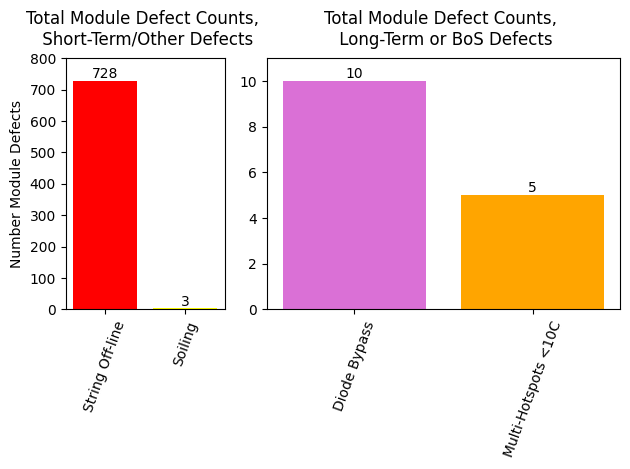

In [12]:
plot_path = "./plots/"
data_fusion.generate_histogram(agg_defect_area_df, site_name, plot_path)